In [14]:
# Imports

import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob

In [4]:
# Loading in all stations, checking how many, and figuring out variable names

base_dir = '/g/data/k10/dl6968/BoM_gauges/netcdf/30min_acc'  
nc_files = []

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.nc'):
            nc_files.append(os.path.join(root, file))

print(f"Found {len(nc_files)} NetCDF files.")

print(nc.Dataset(nc_files[0]))

Found 640 NetCDF files.
<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Record_identifier: st
    Station_Number: 068241
    Rainfall_district_code: 68
    Station_Name: ALBION PARK (SHELLHARBOUR AIRPORT)      
    Station_opened(MM-YYYY): 06/1999
    Station_closed(MM-YYYY):        
    Latitude: -34.5639
    Longitude: 150.7924
    lat-lon_record_method:                
    State: NSW
    Height_station(ABSL): 8.0
    Height_barometer(ABSL):    8.5
    WMO_Number: 95748
    First_year: 1999
    Lastest_year: 2024
    Percentage_of_complete: 83
    Percentage_of_Y: 0
    Percentage_of_N: 100
    Percentage_of_W: 0
    Percentage_of_S: 0
    Percentage_of_I: 0
    EoR_indicator: #
    author: Dongqi Lin (dongqi.lin@monash.edu)
    dimensions(sizes): time(440307)
    variables(dimensions): int64 time(time), float64 prcp(time), <class 'str'> local_time(time), int64 aws_flag(time), float64 quality_flag(time)
    groups: 


In [5]:
# Read each station's metadata into pandas df

station_info = []

for file_path in nc_files:
    ds = nc.Dataset(file_path)

    station_id = getattr(ds, 'Station_Number')
    station_name = getattr(ds, 'Station_Name').strip()
    state = getattr(ds, 'State').strip()
    lat = getattr(ds, 'Latitude')
    lon = getattr(ds, 'Longitude')
    first_year = getattr(ds, 'First_year')
    latest_year = getattr(ds, 'Lastest_year')
    completeness = getattr(ds, 'Percentage_of_complete')

    # Access rainfall data
    rainfall = ds.variables['prcp'][:]

    # Count valid rainfall measurements (non-NaN)
    valid_count = np.count_nonzero(~np.isnan(rainfall))
    total_count = rainfall.shape[0]

    station_info.append({
        'Station Number': station_id,
        'Station Name': station_name,
        'State': state,
        'Latitude': lat,
        'Longitude': lon,
        'Start Year': first_year,
        'End Year': latest_year,
        'Total Observations': total_count,
        'Valid Observations': valid_count,
        'Percentage Complete (from file)': completeness
        #'Quality flag': quality_flag 
    })

    ds.close()

station_data_df = pd.DataFrame(station_info)
station_data_df


,Station Number,Station Name,State,Latitude,Longitude,Start Year,End Year,Total Observations,Valid Observations,Percentage Complete (from file)
0,068241,ALBION PARK (SHELLHARBOUR AIRPORT),NSW,-34.5639,150.7924,1999,2024,440307,361333,83
1,061366,NORAH HEAD AWS,NSW,-33.2814,151.5766,1989,2024,608749,485712,80
2,069128,NERRIGA AWS,NSW,-35.1103,150.0826,2013,2024,193831,190553,99
3,065070,DUBBO AIRPORT AWS,NSW,-32.2206,148.5753,1989,2024,623005,413845,67
4,048244,COBAR COMPARISON,NSW,-31.4861,145.8281,2000,2000,14739,3514,60
...,...,...,...,...,...,...,...,...,...,...
635,014310,OENPELLI AIRPORT,NT,-12.3272,133.0069,2012,2024,206885,199007,97
636,015135,TENNANT CREEK AIRPORT,NT,-19.6423,134.1833,1990,2024,597410,419924,72
637,014704,MCARTHUR RIVER MINE AIRPORT,NT,-16.4423,136.0760,2003,2024,366759,290887,81
638,014309,MURGANELLA AIRSTRIP,NT,-11.5485,132.9266,2012,2024,206212,190748,97


In [ ]:
# Converting necessary columns to numeric types
station_data_df['Percentage Complete (from file)'] = pd.to_numeric(station_data_df['Percentage Complete (from file)'], errors='coerce')
station_data_df['Percentage Complete (from file)'] = station_data_df['Percentage Complete (from file)'].fillna(0)

station_data_df['Start Year'] = pd.to_numeric(station_data_df['Start Year'], errors='coerce')
station_data_df['End Year'] = pd.to_numeric(station_data_df['End Year'], errors='coerce')

# Compute Record Length (in years)
station_data_df['Record Length'] = station_data_df['End Year'] - station_data_df['Start Year'] + 1

In [ ]:
# make summary csv:
station_data_df.to_csv('station_summary.csv', index=False)
print("Summary table saved as station_summary.csv")

Summary table saved as station_summary.csv


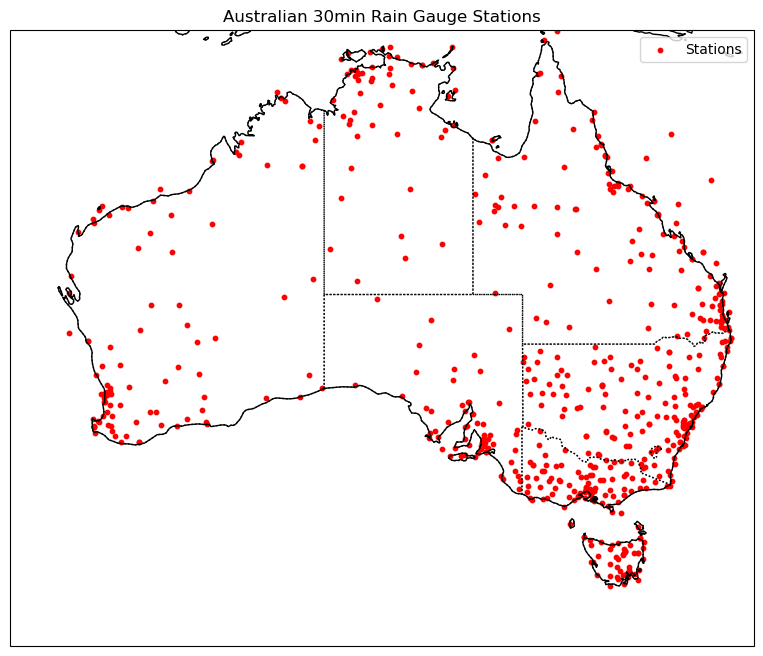

In [5]:
# Creating map of stations across aus:

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_extent([110, 155, -45, -10])


plt.scatter(station_data_df['Longitude'], station_data_df['Latitude'], c='red', s=10, label='Stations')
plt.title('Australian 30min Rain Gauge Stations')
plt.legend()
plt.show()

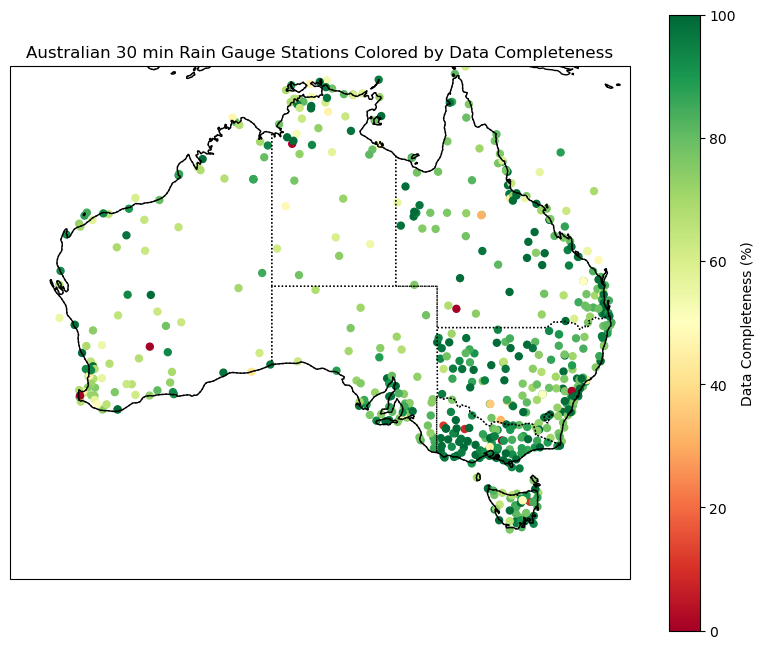

In [6]:
# Colour coding the stations by data completeness:

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_extent([110, 155, -45, -10])

sc = plt.scatter(
    station_data_df['Longitude'], station_data_df['Latitude'],
    c=station_data_df['Percentage Complete (from file)'],
    cmap='RdYlGn',  
    s=25,
    vmin=0, vmax=100,
    transform=ccrs.PlateCarree()
)

plt.colorbar(sc, label='Data Completeness (%)')
plt.title('Australian 30 min Rain Gauge Stations Colored by Data Completeness')
plt.show()

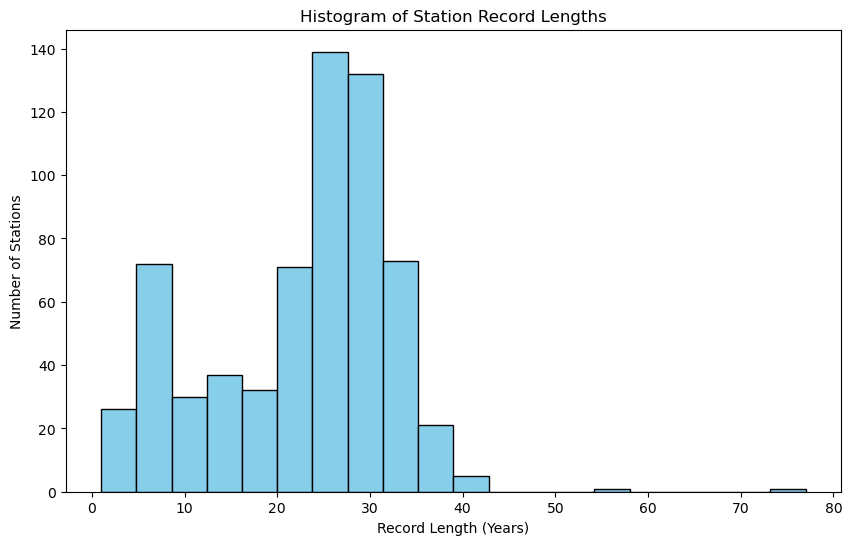

In [7]:
# Plotting histogram of record lengths:

plt.figure(figsize=(10, 6))
plt.hist(station_data_df['Record Length'], edgecolor='black', bins=20, color='skyblue')
plt.xlabel('Record Length (Years)')
plt.ylabel('Number of Stations')
plt.title('Histogram of Station Record Lengths')
plt.show()

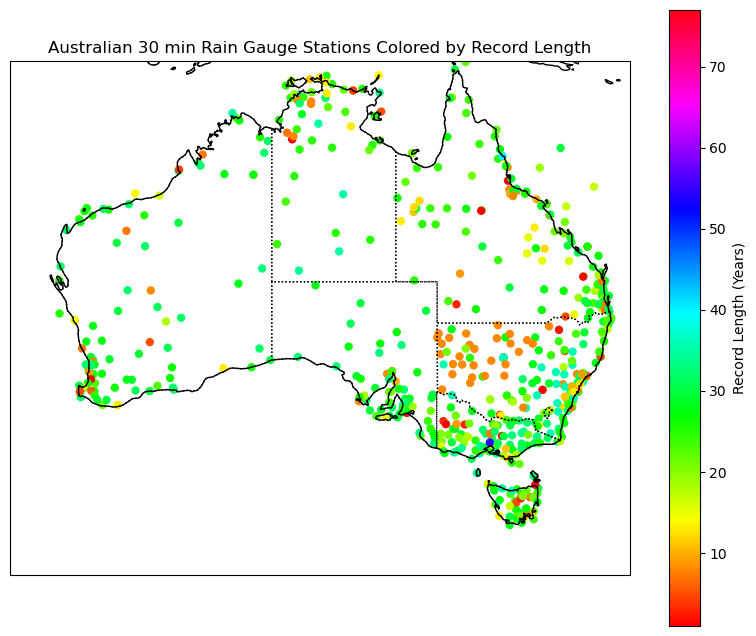

In [8]:
# Colour coding the stations by record length:

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_extent([110, 155, -45, -10])

sc1 = plt.scatter(
    station_data_df['Longitude'], station_data_df['Latitude'],
    c=station_data_df['Record Length'],
    cmap='hsv',
    s=25,
    transform=ccrs.PlateCarree()
)

plt.colorbar(sc1, label='Record Length (Years)')
plt.title('Australian 30 min Rain Gauge Stations Colored by Record Length')
plt.show()

In [15]:
# Separate stations with 30+ years record length by state
longstations_statedict = {}

for _, row in station_data_df.iterrows():
    if row["Record Length"] > 29:
        state = row["State"]
        station_number = row["Station Number"]

        if state not in longstations_statedict:
            longstations_statedict[state] = []
        longstations_statedict[state].append(station_number)

print(longstations_statedict)


{'NSW': ['061366', '065070', '069132', '053115', '066037', '200839', '069139', '058208', '062101', '200288', '061363', '061078', '063291', '069138', '063292', '047048', '068192', '058198', '048237', '062100', '067105', '061260', '073138', '066137', '048027', '070217', '055325', '072150', '072160', '061375', '068228', '070330', '056238', '050137', '070328'], 'TAS': ['094087', '092045', '094029', '091126', '099005', '094008', '097083', '091107', '098017', '097072'], 'ANT': ['300000'], 'QLD': ['033045', '200283', '029127', '040842', '033119', '039083', '044021', '040068', '039123', '032040', '040211', '040004', '036031', '040764', '040717', '033294', '041359', '040861', '027058', '027045', '031011'], 'VIC': ['076031', '085291', '088051', '084144', '084142', '090180', '090173', '083084', '083024', '081123', '086077', '084084', '085072', '090171', '088162', '085296', '090015', '083085', '086361', '082139', '082138', '090175', '087031', '087168', '088164', '084143', '087113', '086282', '0863

In [ ]:
# function for building dataframes containing rain timeseries for specific lists of states:


def build_rain_dataframe(stations, nc_dir, state_abbrev, min_rain=0.01):
    """
    Build a rainfall DataFrame from NetCDF files for a list of stations.
    
    Parameters
    ----------
    stations : list
        List of station numbers.
    nc_dir : str
        Path to directory containing NetCDF files.
    state_abbrev : str
        State abbreviation in full caps (e.g., "VIC", "NSW").
    min_rain : float
        Minimum rainfall to keep (values below this become NaN).
        
    Returns
    -------
    pd.DataFrame
        DataFrame with datetime index, station numbers as columns,
        rainfall values (NaN for < min_rain), only rows with at least one value,
        sorted in chronological order.
    """
    
    all_data = []
    
    for station_num in stations:
        # Assuming files are named like STATE_stationnumber.nc
        file_path = os.path.join(nc_dir, f"{state_abbrev}_{station_num}.nc")
        
        if not os.path.exists(file_path):
            print(f"No file found for station {station_num}")
            continue
        
        # Open NetCDF
        ds = nc.Dataset(file_path)
        
        # Time variable
        time_var = ds.variables["time"]
        times = nc.num2date(time_var[:], units=time_var.units)
        times = [datetime(t.year, t.month, t.day, t.hour, t.minute, t.second) for t in times]
        
        # Rain variable
        rain = ds.variables['prcp'][:]
        
        # Filter out small rainfall values
        rain = pd.Series(rain)
        rain = rain.where(rain >= min_rain, other=float('nan'))
        
        # Build DataFrame for this station
        df_station = pd.DataFrame({station_num: rain.values}, index=pd.to_datetime(times))
        df_station = df_station[~df_station.index.duplicated(keep='first')]
        
        all_data.append(df_station)
        ds.close()
    
    # Combine all stations, drop all-NaN rows, sort by datetime
    df_all = pd.concat(all_data, axis=1)
    df_all = df_all.dropna(how="all")
    df_all = df_all.sort_index()
    
    return df_all


In [ ]:
vic30yr_df = build_rain_dataframe(stations=longstations_statedict["VIC"], nc_dir='/g/data/k10/dl6968/BoM_gauges/netcdf/30min_acc/VIC', 
                              state_abbrev="VIC", min_rain=0.01)

vic30yr_df

,076031,085291,088051,084144,084142,090180,090173,083084,083024,081123,...,087031,087168,088164,084143,087113,086282,086383,090176,088109,086373
1991-08-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.6
1991-08-31 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
1991-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1991-09-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1991-09-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15 04:00:00,0.2,5.4,NaN,1.2,NaN,2.2,0.6,1.4,NaN,NaN,...,0.6,0.2,1.4,NaN,0.4,0.2,3.4,0.4,NaN,4.8
2024-07-15 04:30:00,0.2,7.2,NaN,1.6,NaN,2.6,0.6,1.8,NaN,NaN,...,0.8,0.4,1.6,0.2,0.8,0.4,3.8,0.4,NaN,4.8
2024-07-15 05:00:00,0.2,8.8,NaN,2.6,NaN,2.8,1.2,1.8,NaN,NaN,...,1.0,0.8,1.6,0.4,1.2,0.4,4.4,0.4,NaN,5.0
2024-07-15 05:30:00,0.2,10.0,NaN,3.4,NaN,3.0,1.4,2.2,NaN,NaN,...,1.2,1.2,1.8,0.6,1.4,0.4,4.8,0.6,0.2,5.2
